<a href="https://colab.research.google.com/github/olinml2024/notebooks/blob/main/ML24_Day09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Showing Parallels Between Micrograd and Pytorch

We jumped pretty fast into some fairly complex pytorch functions.  Let's rewind a bit and look at some pretty basic functions and make sure we get the results we expect.  We will see through doing this that pytorch is very similar to micrograd.

In [1]:
import torch

# try setting requires_grad to false and see what happens
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(7.0, requires_grad=True)
z = x*y**2 + x*y
z.backward()
print(x.grad)            # should be y**2 + y = y**2 + 7 = 56
print(y.grad)            # should be 2*x*y + x = 2*1*7 + 1 = 15

tensor(56.)
tensor(15.)


# Revisiting Linear Regression in Pytorch

It's also nice to be able to go back to one of the first problems we saw in this module: fitting a line to data with linear regression.  Let's look at that simple problem in pytorch to give ourselves some more practice and to create some nice visuals.

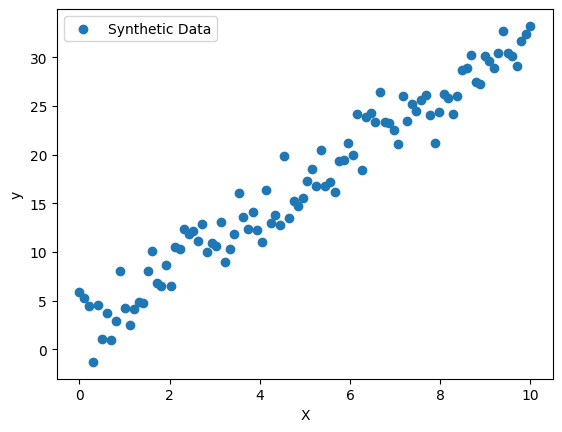

In [4]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate synthetic dataset (y = 3x + 2 + noise)
torch.manual_seed(42)  # For reproducibility
n_samples = 100
X = torch.linspace(0, 10, n_samples).unsqueeze(1)  # Shape (n_samples, 1)
true_slope = 3.0
true_intercept = 2.0
noise = torch.randn(X.size()) * 2
y = true_slope * X + true_intercept + noise
plt.scatter(X.numpy(), y.numpy(), label='Synthetic Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Next, we are going to use linear regression to compute a line of best fit.  We saw in the assignment how pytorch's ``Linear`` class might be useful for that.  Right now, we are going to bring it back to basics and build from scratch.  In the code below we perform the following steps.

1. Define a model as yhat = mx + b
2. Plot the loss of the model on our data in parameter space (m and b).
3. Use pytorch to get gradients at a bunch of points in parameter space.
4. Show the steps taken by gradident descent as it modifies these parameters to minimize the loss.

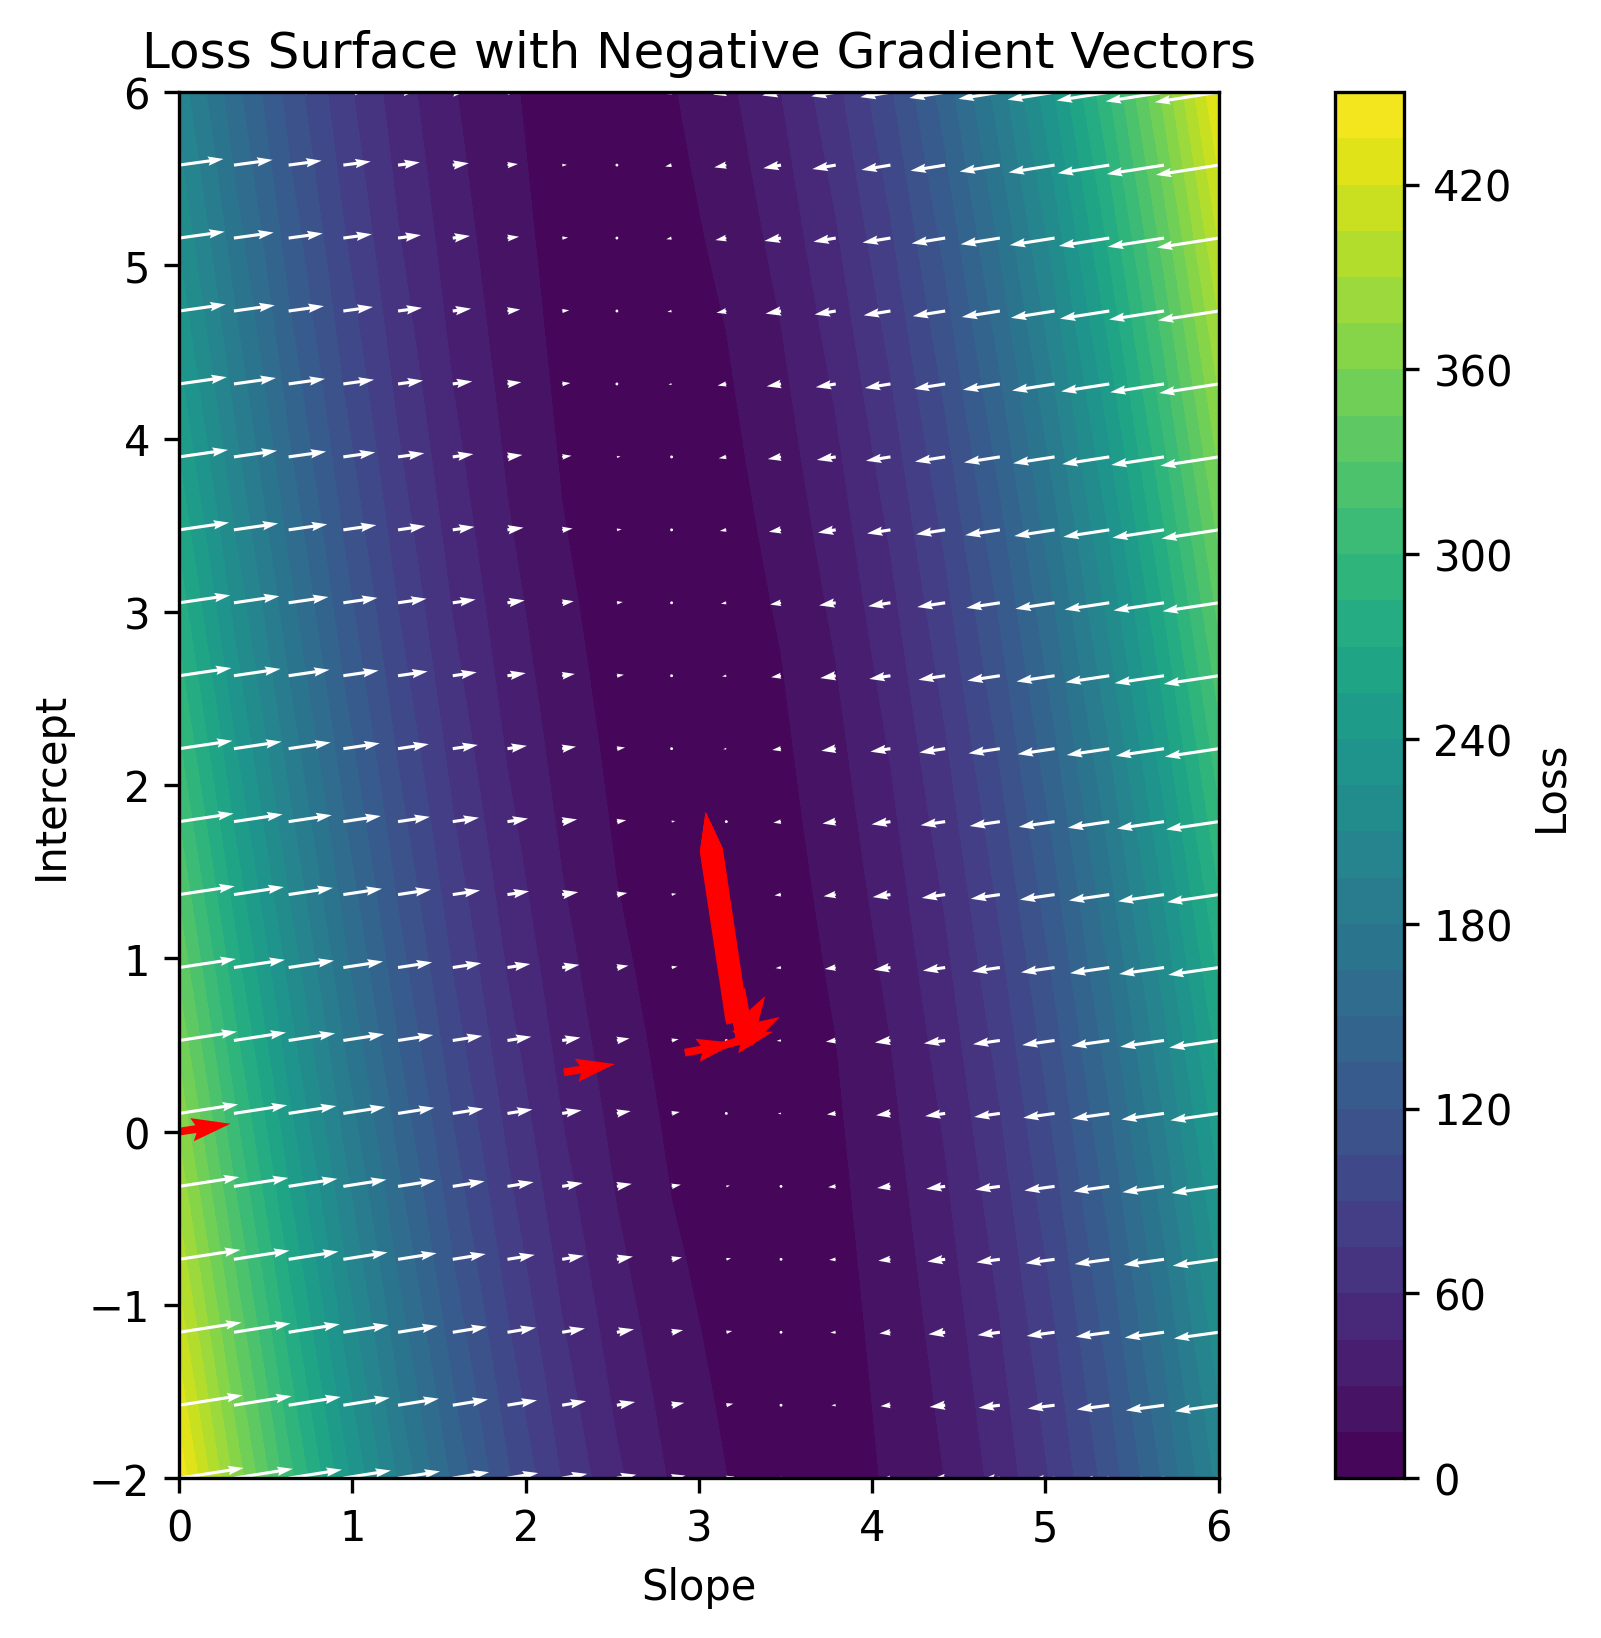

In [5]:
# Define our model
m = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# Define mean squared error loss (this is just taking the average of (yhat - y)^2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD([m, b], lr=0.01)

def plot_loss_surface_with_gradients(m, b, X, y, slope_range, intercept_range):
    """ Plot the loss surface and the gradient vectors """
    plt.figure(figsize=(10, 6), dpi=300)
    plt.axes().set_aspect('equal')
    slopes = np.linspace(slope_range[0], slope_range[1], 20)
    intercepts = np.linspace(intercept_range[0], intercept_range[1], 20)
    losses = np.zeros((len(slopes), len(intercepts)))
    grad_slope = np.zeros((len(slopes), len(intercepts)))
    grad_intercept = np.zeros((len(slopes), len(intercepts)))

    for i, slope in enumerate(slopes):
        for j, intercept in enumerate(intercepts):
            # Set model parameters based on where we are in the meshgrid
            m = torch.tensor(slope, requires_grad=True)
            b = torch.tensor(intercept, requires_grad=True)

            # calculate our predictions
            predictions = m*X + b
            # use pytorch's built-in squared error loss (we could do our own)
            loss = criterion(predictions, y)
            losses[i, j] = loss.item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backward pass for gradient calculation
            loss.backward()

            # Store gradients of the slope and intercept
            grad_slope[i, j] = m.grad.item()
            grad_intercept[i, j] = b.grad.item()

    # Plot the loss surface as a contour plot
    S, I = np.meshgrid(slopes, intercepts)
    plt.contourf(S, I, losses.T, levels=30, cmap='viridis')
    plt.colorbar(label="Loss")

    # Use quiver to display the negative gradients
    plt.quiver(S, I, -grad_slope.T, -grad_intercept.T, color='white')
    plt.xlabel('Slope')
    plt.ylabel('Intercept')
    plt.title('Loss Surface with Negative Gradient Vectors')

plot_loss_surface_with_gradients(m, b, X, y, slope_range=(0, 6), intercept_range=(-2, 6))

# initialize the model slope and y-intercept so we can do gradient descent
m = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# this optimizer gives us gradient descent, but we could do this easily ourselves
optimizer = torch.optim.SGD([m, b], lr=0.01)

# Let's do 200 gradient descent steps (also called epochs)
epochs = 200
for epoch in range(epochs):
    # Forward pass
    predictions = m*X + b
    loss = criterion(predictions, y)

    # Backward pass and gradient computation
    optimizer.zero_grad()
    loss.backward()
    u = m.grad.item()
    v = b.grad.item()
    # show the negative of the gradient vector
    plt.quiver(m.item(), b.item(), -u / np.sqrt(u**2 + v**2), -v / np.sqrt(u**2 + v**2), scale=20, color='red')
    # Update parameters
    optimizer.step()
plt.show()

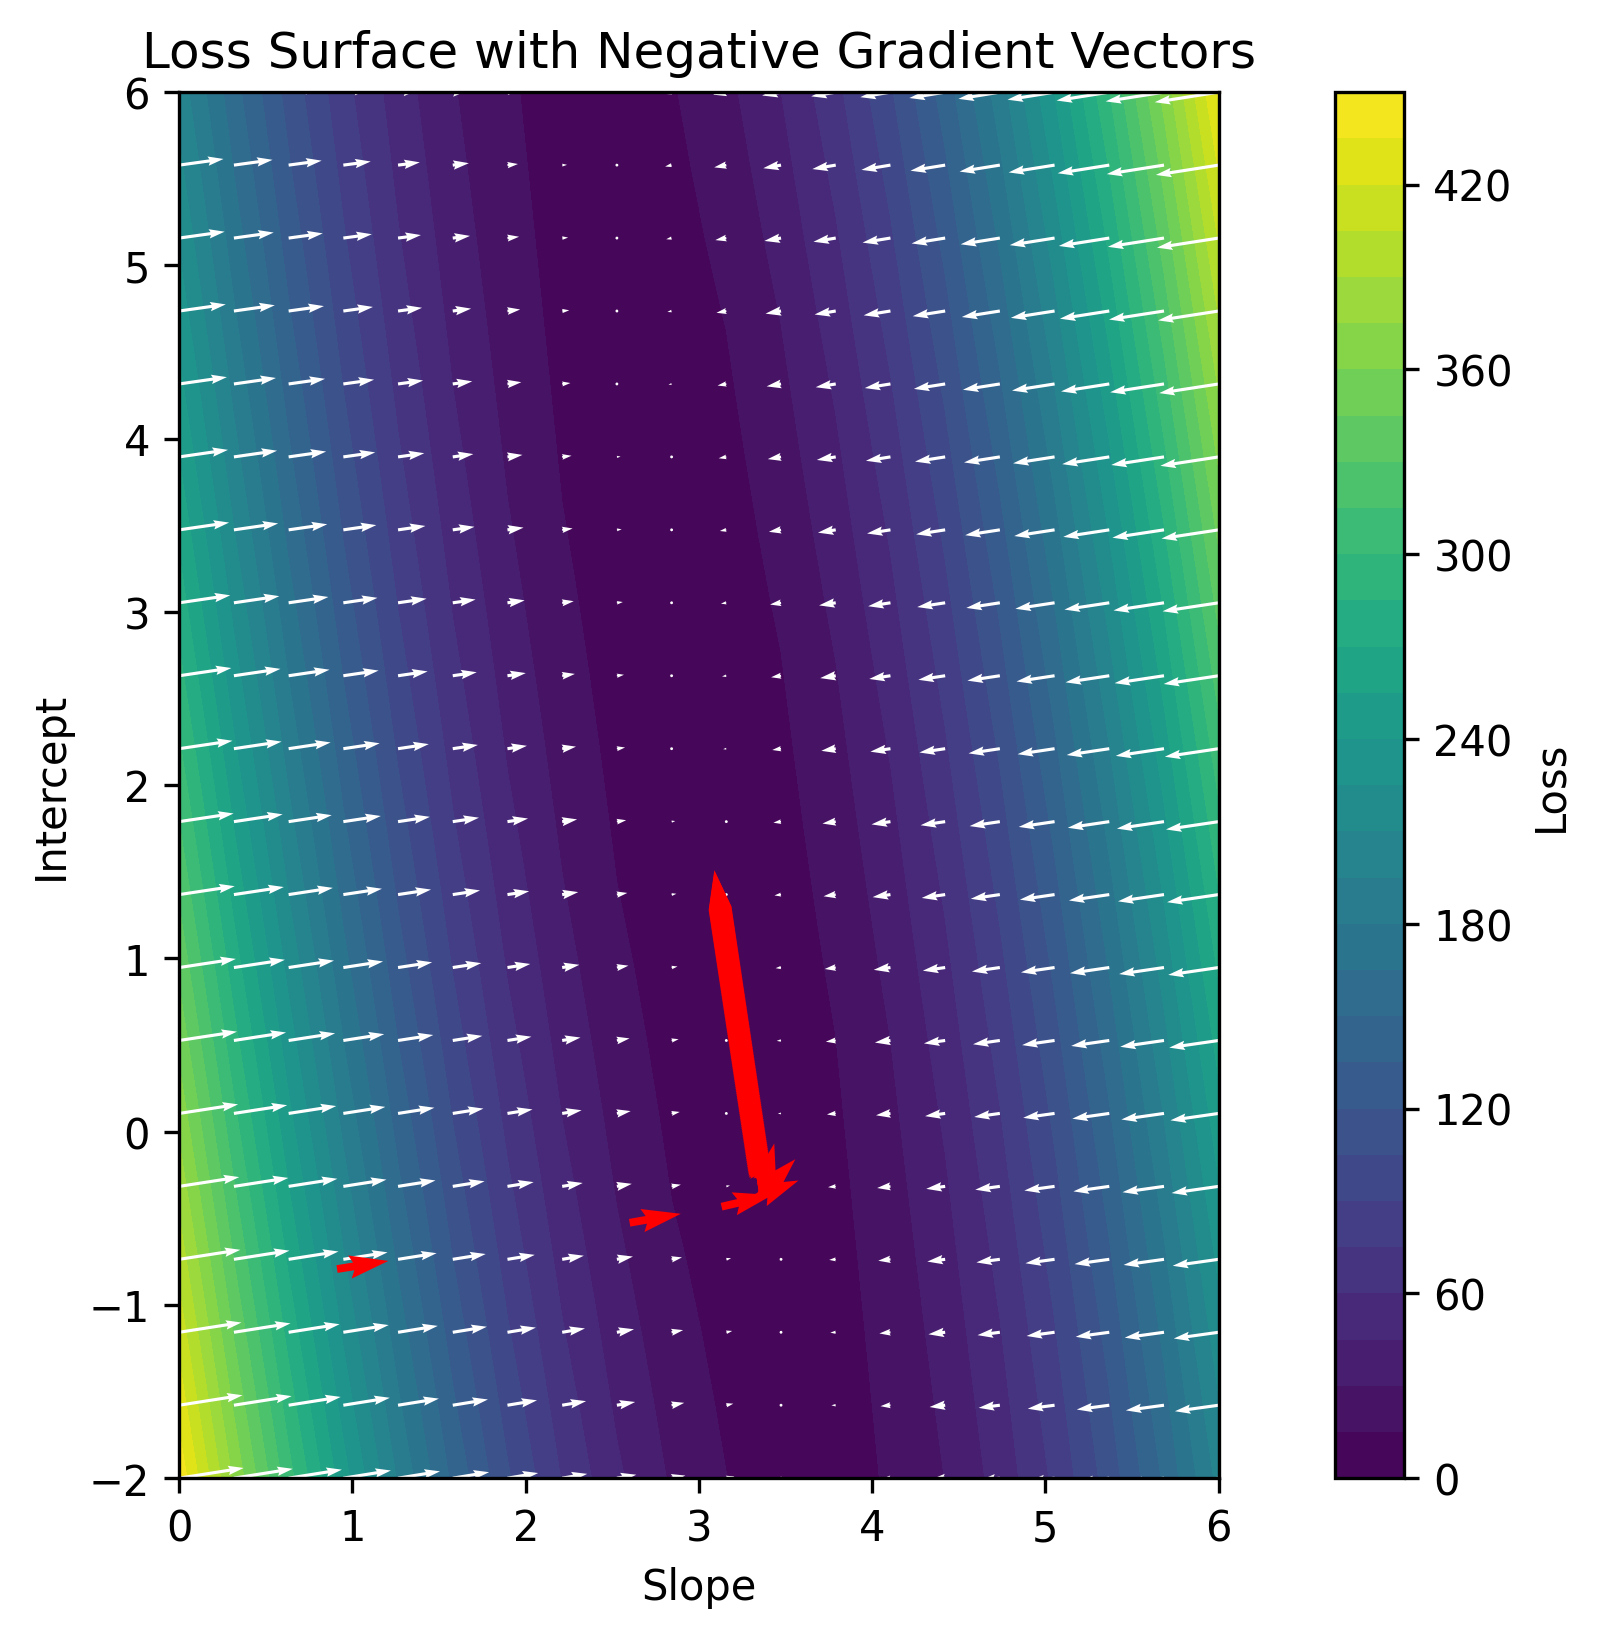

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 2. Define a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # One input, one output

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()

# Define mean squared error loss (this is just taking the average of (yhat - y)^2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def plot_loss_surface_with_gradients(model, X, y, slope_range, intercept_range):
    """ Plot the loss surface and the gradient vectors """
    plt.figure(figsize=(10, 6), dpi=300)
    plt.axes().set_aspect('equal')
    slopes = np.linspace(slope_range[0], slope_range[1], 20)
    intercepts = np.linspace(intercept_range[0], intercept_range[1], 20)
    losses = np.zeros((len(slopes), len(intercepts)))
    grad_slope = np.zeros((len(slopes), len(intercepts)))
    grad_intercept = np.zeros((len(slopes), len(intercepts)))

    for i, slope in enumerate(slopes):
        for j, intercept in enumerate(intercepts):
            # Set model parameters based on where we are in the meshgrid
            model.linear.weight.data.fill_(slope)
            model.linear.bias.data.fill_(intercept)

            # calculate our predictions
            predictions = model(X)
            # use pytorch's built-in squared error loss (we could do our own)
            loss = criterion(predictions, y)
            losses[i, j] = loss.item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backward pass for gradient calculation
            loss.backward()

            # Store gradients of the slope and intercept
            grad_slope[i, j] = model.linear.weight.grad.item()
            grad_intercept[i, j] = model.linear.bias.grad.item()

    # Plot the loss surface as a contour plot
    S, I = np.meshgrid(slopes, intercepts)
    plt.contourf(S, I, losses.T, levels=30, cmap='viridis')
    plt.colorbar(label="Loss")

    # Use quiver to display the negative gradients
    plt.quiver(S, I, -grad_slope.T, -grad_intercept.T, color='white')
    plt.xlabel('Slope')
    plt.ylabel('Intercept')
    plt.title('Loss Surface with Negative Gradient Vectors')

plot_loss_surface_with_gradients(model, X, y, slope_range=(0, 6), intercept_range=(-2, 6))


model = LinearRegressionModel()
# this optimizer gives us gradient descent, but we could do this easily ourselves
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Let's do 200 gradient descent steps (also called epochs)
epochs = 200
for epoch in range(epochs):
    # Forward pass
    predictions = model(X)
    loss = criterion(predictions, y)

    # Backward pass and gradient computation
    optimizer.zero_grad()
    loss.backward()
    u = model.linear.weight.grad.item()
    v = model.linear.bias.grad.item()
    # show the negative of the gradient vector
    plt.quiver(model.linear.weight.item(), model.linear.bias.item(), -u / np.sqrt(u**2 + v**2), -v / np.sqrt(u**2 + v**2), scale=20, color='red')
    # Update parameters
    optimizer.step()
plt.show()